In [1]:
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


#### Function to generate random pytorch sequential model architechture

In [2]:
import torch
import torch.nn as nn
import random

def generate_random_network():
    layers = []
    input_channels = random.randint(1, 3)
    input_size = random.randint(32, 224)
    output_size = random.randint(1, 10)
    num_layers = random.randint(2, 5)

    current_channels = input_channels
    current_size = input_size

    for i in range(num_layers):
        # Randomly choose layer type
        layer_type = random.choice(['linear', 'conv1d', 'conv2d'] if i < num_layers - 1 else ['linear'])

        if layer_type == 'linear':
            if i == 0:
                in_features = current_channels * current_size * current_size
            else:
                in_features = get_output_features(layers[-1], current_channels, current_size)
            out_features = random.randint(10, 200) if i < num_layers - 1 else output_size
            layers.append(nn.Linear(in_features, out_features))
            current_channels = 1
            current_size = out_features
        elif layer_type == 'conv1d':
            out_channels = random.randint(16, 64)
            layers.append(nn.Conv1d(current_channels, out_channels, kernel_size=3, padding=1))
            current_channels = out_channels
        elif layer_type == 'conv2d':
            out_channels = random.randint(16, 64)
            layers.append(nn.Conv2d(current_channels, out_channels, kernel_size=3, padding=1))
            current_channels = out_channels

        # Randomly add normalization
        if random.choice([True, False]):
            if layer_type == 'linear':
                layers.append(nn.BatchNorm1d(out_features))
            elif layer_type == 'conv1d':
                layers.append(nn.BatchNorm1d(out_channels))
            elif layer_type == 'conv2d':
                layers.append(nn.BatchNorm2d(out_channels))

        # Randomly add activation functions
        if random.choice([True, False]):
            layers.append(random.choice([nn.ReLU(), nn.LeakyReLU(), nn.Tanh(), nn.Sigmoid()]))

        # Randomly add dropout
        if random.choice([True, False]):
            layers.append(nn.Dropout(p=random.uniform(0.1, 0.5)))

    # Ensure the last layer is Linear and outputs the correct size
    if not isinstance(layers[-1], nn.Linear) or layers[-1].out_features != output_size:
        in_features = get_output_features(layers[-1], current_channels, current_size)
        layers.append(nn.Linear(in_features, output_size))

    return nn.Sequential(*layers)

def get_output_features(layer, current_channels, current_size):
    if isinstance(layer, nn.Linear):
        return layer.out_features
    elif isinstance(layer, (nn.Conv1d, nn.Conv2d)):
        return layer.out_channels
    elif isinstance(layer, (nn.BatchNorm1d, nn.BatchNorm2d)):
        return layer.num_features
    elif isinstance(layer, (nn.ReLU, nn.LeakyReLU, nn.Tanh, nn.Sigmoid, nn.Dropout)):
        return current_channels * current_size * current_size
    else:
        raise ValueError(f"Unsupported layer type: {type(layer)}")

# Test the function
try:
    model = generate_random_network()
    print(model)
except Exception as e:
    print(f"An error occurred: {e}")

Sequential(
  (0): Conv1d(3, 40, kernel_size=(3,), stride=(1,), padding=(1,))
  (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.28157632649973624, inplace=False)
  (4): Linear(in_features=739840, out_features=178, bias=True)
  (5): BatchNorm1d(178, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.01)
  (7): Linear(in_features=31684, out_features=7, bias=True)
  (8): Sigmoid()
  (9): Dropout(p=0.16797290166241496, inplace=False)
  (10): Linear(in_features=49, out_features=7, bias=True)
)


#### Function to generate description of any model architechture (Assumption: No input and output will have more than three dimensions.)

In [3]:
def generate_description(model):
    layers = list(model.children())

    # Determine input shape
    first_layer = layers[0]
    if isinstance(first_layer, nn.Linear):
        input_shape = f"b,{first_layer.in_features}"
    elif isinstance(first_layer, nn.Conv1d):
        input_shape = f"b,{first_layer.in_channels},w"
    elif isinstance(first_layer, nn.Conv2d):
        input_shape = f"b,{first_layer.in_channels},h,w"
    else:
        input_shape = "unknown"

    # Determine output shape
    last_layer = next((layer for layer in reversed(layers) if isinstance(layer, nn.Linear)), None)
    if last_layer:
        output_shape = f"b,{last_layer.out_features}"
    else:
        output_shape = "unknown"

    description = f"This neural network takes an input of shape ({input_shape}) "
    description += f"and produces an output of shape ({output_shape}). "
    description += f"It consists of {len(layers)} layers, including "

    layer_descriptions = []
    for layer in layers:
        if isinstance(layer, nn.Linear):
            layer_descriptions.append(f"a Linear layer ({layer.in_features} -> {layer.out_features})")
        elif isinstance(layer, nn.Conv1d):
            layer_descriptions.append(f"a 1D Convolutional layer ({layer.in_channels} -> {layer.out_channels}, kernel_size={layer.kernel_size[0]})")
        elif isinstance(layer, nn.Conv2d):
            layer_descriptions.append(f"a 2D Convolutional layer ({layer.in_channels} -> {layer.out_channels}, kernel_size={layer.kernel_size})")
        elif isinstance(layer, nn.BatchNorm1d):
            layer_descriptions.append(f"a 1D Batch Normalization (num_features={layer.num_features})")
        elif isinstance(layer, nn.BatchNorm2d):
            layer_descriptions.append(f"a 2D Batch Normalization (num_features={layer.num_features})")
        elif isinstance(layer, nn.ReLU):
            layer_descriptions.append("a ReLU activation")
        elif isinstance(layer, nn.LeakyReLU):
            layer_descriptions.append(f"a Leaky ReLU activation (negative_slope={layer.negative_slope:.2f})")
        elif isinstance(layer, nn.Tanh):
            layer_descriptions.append("a Tanh activation")
        elif isinstance(layer, nn.Sigmoid):
            layer_descriptions.append("a Sigmoid activation")
        elif isinstance(layer, nn.Dropout):
            layer_descriptions.append(f"a Dropout layer (p={layer.p:.2f})")
        else:
            layer_descriptions.append(f"an unknown layer type: {type(layer).__name__}")

    description += ", ".join(layer_descriptions) + "."
    return description

# Example usage:
model = generate_random_network()
description = generate_description(model)
print(description)

This neural network takes an input of shape (b,1,w) and produces an output of shape (b,9). It consists of 9 layers, including a 1D Convolutional layer (1 -> 61, kernel_size=3), a 1D Batch Normalization (num_features=61), a Dropout layer (p=0.22), a 1D Convolutional layer (61 -> 44, kernel_size=3), a Linear layer (44 -> 104), a Linear layer (104 -> 9), a 1D Batch Normalization (num_features=9), a Sigmoid activation, a Linear layer (81 -> 9).


In [4]:
## Function to generate dataset of model architecture and corresponding description
import gc
def generate_dataset(num_samples):
    dataset = []
    for _ in range(num_samples):
        model = generate_random_network()
        description = generate_description(model)
        dataset.append((str(model), description)) ## Convert model to string
        # Explicitly delete variables and run garbage collection
        del model
        del description
        gc.collect()
    return dataset

# Generate samples dataset
# sample_df = generate_dataset(100)

In [ ]:
import pickle

def save_dataset(dataset, filename):
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)

# save_dataset(sample_df, 'neural_network_dataset.pkl')

#### I have defined a PyTorch module for a Transformer-based sequence-to-sequence (Seq2Seq) model.
The constructor takes several parameters to configure the model:

* `input_dim`: Size of the input vocabulary
* `output_dim`: Size of the output vocabulary
* `d_model`: Dimensionality of the model (default: 512)
* `nhead`: Number of attention heads (default: 8)
* `num_encoder_layers`: Number of encoder layers (default: 6)
* `num_decoder_layers`: Number of decoder layers (default: 6)
* `dim_feedforward`: Dimension of the feedforward network (default: 2048)
* `dropout`: Dropout rate (default: 0.1)

Model Components:
* `self.transformer`: The core Transformer model from PyTorch
* `self.fc_out`: A linear layer to project the transformer output to the output dimension
* `self.src_tok_emb`: Embedding layer for source tokens
* `self.tgt_tok_emb`: Embedding layer for target tokens
* `self.positional_encoding`: Positional encoding implemented as an embedding layer

In [5]:
# !pip install transformers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

class TransformerSeq2Seq(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=512, nhead=8, num_encoder_layers=6, num_decoder_layers=6, dim_feedforward=2048, dropout=0.1):
        super(TransformerSeq2Seq, self).__init__()
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, output_dim)
        self.src_tok_emb = nn.Embedding(input_dim, d_model)
        self.tgt_tok_emb = nn.Embedding(output_dim, d_model)
        self.positional_encoding = nn.Embedding(5000, d_model) # let's take 5000 as the maximum sequence length that the model can handle.

    def forward(self, src, tgt):
        src_seq_len, N = src.shape
        tgt_seq_len, N = tgt.shape

        src_positions = (
            torch.arange(0, src_seq_len).unsqueeze(1).expand(src_seq_len, N).to(src.device)
        )
        tgt_positions = (
            torch.arange(0, tgt_seq_len).unsqueeze(1).expand(tgt_seq_len, N).to(tgt.device)
        )

        embed_src = self.src_tok_emb(src) + self.positional_encoding(src_positions)
        embed_tgt = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt_positions)

        transformer_out = self.transformer(embed_src, embed_tgt)
        out = self.fc_out(transformer_out)

        return out



The architecture follows the standard Transformer model for sequence-to-sequence tasks, with separate embeddings for source and target tokens, and added positional encodings. The model can be used for tasks like translation, where you have an input sequence (source) and want to generate an output sequence (target).

In [ ]:
## Function to tokenize the dataset
class SyntheticDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_text, output_text = self.data[idx]

        # Tokenize input and output texts
        input_encoding = self.tokenizer(input_text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        output_encoding = self.tokenizer(output_text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')

        # Extract input and output IDs
        input_ids = input_encoding['input_ids'].squeeze(0)  # Remove batch dimension
        output_ids = output_encoding['input_ids'].squeeze(0)  # Remove batch dimension

        return input_ids, output_ids


In [ ]:
from transformers import BertTokenizer
# device will be 'cuda' if a GPU is available and 'cpu' otherwise
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = TransformerSeq2Seq(len(tokenizer.vocab), len(tokenizer.vocab)).to(device)  # Move the model to the device
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()


# # Example data
# example_input = "Sequential((0): Linear(in_features=38809, out_features=26, bias=True) (1): LeakyReLU(negative_slope=0.01) (2): Linear(in_features=676, out_features=183, bias=True) (3): BatchNorm1d(183, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) (4): LeakyReLU(negative_slope=0.01) (5): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) (6): Dropout(p=0.11890518865721189, inplace=False) (7): Linear(in_features=837225, out_features=8, bias=True))"
# example_output = "This neural network takes an input of shape (b,38809) and produces an output of shape (b,8). It consists of 8 layers, including a Linear layer (38809 -> 26), a Leaky ReLU activation (negative_slope=0.01), a Linear layer (676 -> 183), a 1D Batch Normalization (num_features=183), a Leaky ReLU activation (negative_slope=0.01), a 2D Convolutional layer (1 -> 25, kernel_size=(3, 3)), a Dropout layer (p=0.12), a Linear layer (837225 -> 8)."

# Create dataset
# data = [(example_input, example_output)]
data = generate_dataset(100)
dataset = SyntheticDataset(data, tokenizer)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Print the first batch to verify
for batch in dataloader:
    src, tgt = batch
    print("Source Shape:", src.shape)
    print("Target Shape:", tgt.shape)
    break

In [ ]:
# Function to train the model with checkpointing
def train_with_checkpointing(model, dataloader, optimizer, criterion, num_epochs=10, patience=3, checkpoint_path='/content/drive/MyDrive/ShodhAI/checkpoint.pt'):
    model.train()
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        epoch_loss = 0

        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            optimizer.zero_grad()

            output = model(src, tgt[:-1, :])
            output = output.reshape(-1, output.shape[2])
            tgt = tgt[1:, :].reshape(-1)

            loss = criterion(output, tgt)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f'Epoch {epoch+1}, Loss: {avg_epoch_loss}')

        # Checkpointing
        if avg_epoch_loss < best_loss:
            best_loss = avg_epoch_loss
            torch.save(model.state_dict(), checkpoint_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping')
                break

# Train the model with checkpointing
train_with_checkpointing(model, dataloader, optimizer, criterion, num_epochs=20, patience=3)


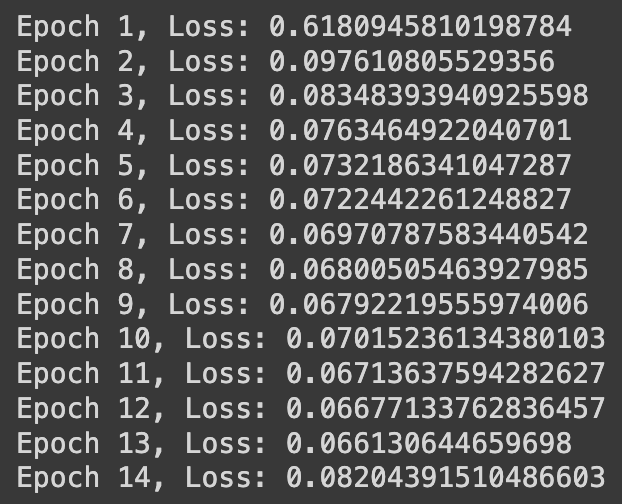

In [ ]:
import torch
import warnings
warnings.filterwarnings('ignore')
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


def calculate_metrics(predictions, targets, tokenizer):
    print("prediction", predictions)
    print("targets", targets)
    pred_tokens = [pred.split() for pred in predictions]
    target_tokens = [tgt.split() for tgt in targets]
    # Flatten the list of lists
    pred_flat = [token for sent in pred_tokens for token in sent]
    target_flat = [token for sent in target_tokens for token in sent]
    ##Adjust the dimention
    length = min(len(pred_flat), len(target_flat))
    pred_flat = pred_flat[:length]
    target_flat = target_flat[:length]
    print("*"*50)
    print(pred_flat, target_flat)
    print("*"*50)
    # Convert tokens to IDs
    pred_ids = tokenizer.convert_tokens_to_ids(pred_flat)
    target_ids = tokenizer.convert_tokens_to_ids(target_flat)
    
    # Ensure we use the same set of unique tokens for both
    unique_tokens = list(set(pred_ids + target_ids))
    
    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(target_ids, pred_ids, labels=unique_tokens, average='weighted')
    accuracy = accuracy_score(target_ids, pred_ids)
    
    return precision, recall, f1, accuracy

def test_model(model, tokenizer, test_data, batch_size=32):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Prepare DataLoader for testing
    test_dataset = SyntheticDataset(test_data, tokenizer)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Set model to evaluation mode
    model.eval()
    
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_idx, (src, tgt) in enumerate(test_dataloader):
            src, tgt = src.to(device), tgt.to(device)
            
            # Generate predictions
            output = model(src, tgt[:-1, :])  # Remove last token from target for prediction
            predicted_ids = torch.argmax(output, dim=-1)
            
            # Convert predicted IDs to tokens
            predicted_tokens = tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)
            target_tokens = tokenizer.batch_decode(tgt, skip_special_tokens=True)
            
            # Store predictions and targets
            all_predictions.extend(predicted_tokens)
            all_targets.extend(target_tokens)
    
    # Compute F1 score
    precision, recall, f1, accuracy = calculate_metrics(all_predictions, all_targets, tokenizer)
    
    return precision, recall, f1, accuracy

def main():
    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    test_data = generate_dataset(20) # [(example source, example_target)]

    # Initialize and load your TransformerSeq2Seq model
    model = TransformerSeq2Seq(input_dim=len(tokenizer.vocab), output_dim=len(tokenizer.vocab))
    model.load_state_dict(torch.load('/content/drive/MyDrive/ShodhAI/checkpoint.pt', map_location=torch.device('cpu')))  # Load your trained model checkpoint `map_location=torch.device('cpu')` on cpu
    # model.to(device)

    # Test the model
    precision, recall, f1, accuracy = test_model(model, tokenizer, test_data)

    print("precision", precision)
    print("Recall", recall)
    print("f1 score", f1)
    print("accuracy", accuracy)

if __name__ == "__main__":
    main()

### To further improve the model performance (Accuracy and f1 score) we can try below techniques

* #### Increase Training Data:
  Generate more synthetic neural network architectures and their descriptions to provide diverse examples.

* #### Fine-Tune Hyperparameters:
  Experiment with learning rates, batch sizes, and the number of epochs to find the optimal settings for better model performance.

* #### Leverage Pretrained Models:
  Use pretrained models like BERT, GPT, or T5 and fine-tune them on the specific task to leverage their rich knowledge base.

* #### Advanced Decoding Techniques:
  Implement beam search decoding to explore multiple possible sequences during prediction and select the most likely one.